# DISSERTATION ANALYSIS

In [1]:
source("tools.R")

Warning message:
"package 'plyr' was built under R version 3.3.3"Warning message:
"package 'tidyverse' was built under R version 3.3.3"Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'tibble' was built under R version 3.3.3"Warning message:
"package 'tidyr' was built under R version 3.3.3"Warning message:
"package 'readr' was built under R version 3.3.3"Warning message:
"package 'purrr' was built under R version 3.3.3"Warning message:
"package 'dplyr' was built under R version 3.3.3"Conflicts with tidy packages ---------------------------------------------------
arrange():   dplyr, plyr
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
mutate():    dplyr, plyr
rename():    dplyr, plyr
summa

# UNIVERSAL FUNCTIONS AND VARIABLE

In [15]:
scenarios <- c("temperature", "rain", "sales", "gym_memberships", "wage", "facebook_friends")

readable_scenarios <- c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends")

subconditions = c(1, 2, 3)

condition_names = c("Prior", "Posterior-Positive", "Posterior-Stable", "Posterior-Negative")

In [16]:
get_range <- function(condition){
    
    range_array <- switch(
            condition,
            temperature = c(-10, 40),
            sales = c(0, 5000),
            facebook_friends = c(0, 1000),
            rain = c(0, 100),
            gym_memberships = c(0, 50),
            wage = c(0, 50)
        )
    
    range_value <- range_array[2] - range_array[1]
    
    delta <- range_value / 10
    
    c(range_array[1] - delta, range_array[2] + delta)
}

# IMPORTING DATA: `data`

In [17]:
# Import data
data <- suppressWarnings(read_csv("data/catmull-rom-dataset.csv"))

# Small modification
data$noiseIndex <- data$noiseIndex+1

# All participants
participants <- data %>%
                select(userId, age, gender) %>%
                unique

Parsed with column specification:
cols(
  .default = col_double(),
  userId = col_character(),
  age = col_character(),
  datetime = col_character(),
  gender = col_character(),
  datetime_1 = col_character(),
  stage = col_integer(),
  scenario = col_character(),
  subcondition = col_integer(),
  pageIndex = col_integer(),
  noiseIndex = col_integer(),
  day0 = col_character(),
  day1 = col_character(),
  day2 = col_character(),
  day3 = col_character(),
  day4 = col_character(),
  day5 = col_character(),
  day6 = col_character(),
  day7 = col_character(),
  day8 = col_character(),
  day9 = col_character()
  # ... with 69 more columns
)
See spec(...) for full column specifications.


### Suppressing invalid participants
- `a106`: Participant misunderstood the instructions and always added a point on the far right and far bottom.
- `a118`: Participant indicated that he had trouble with the interface.
- `a021`: Response in Temperature (constant -10) indicates a non-interested participant. ***Was not supressed ***

In [18]:
data <- data %>% filter(userId != 'a106',userId != 'a118')

### Tidyverse: `tidy_data`

In [19]:
# To tidy data
tidy_data <- data %>% 
    gather(day, value, starts_with("day"))

# Transform strings to numbers
tidy_data <- tidy_data %>%
    mutate(day = as.numeric(gsub("day", "", day)),
           value = as.numeric(value))

# Changes values to make them readable
# TODO: make this tidier:
tidy_data$subcondition_name <- mapvalues(tidy_data$subcondition,
                                  from = subconditions,
                                  to   = condition_names[2:4])

tidy_data$condition_name <- ifelse(tidy_data$stage==1,
                                   condition_names[1], 
                                   "")

tidy_data$condition_name <- ifelse(tidy_data$stage == 2, 
                                   tidy_data$subcondition_name, 
                                   tidy_data$condition_name)

Warning message in eval(substitute(expr), envir, enclos):
"NAs introduced by coercion"

### Preparing the tidy data for analysis: `dat`

In [20]:
dat <- data.frame(
                    id        = tidy_data$userId,
                    day       = tidy_data$day, #x
                    value     = tidy_data$value, #y
                    condition = tidy_data$condition_name,
                    scenario  = tidy_data$scenario,
                    noise     = tidy_data$noiseIndex
                 )

# Change the readable names of the variables
dat$scenario <- mapvalues( dat$scenario, 
                           from = scenarios,
                           to = readable_scenarios)


# Order on the plot
dat$condition <- factor( dat$condition, 
                         levels = condition_names)

dat$scenario <- factor( dat$scenario, 
                        levels = readable_scenarios)

# Subset the analysis of data
dat <- subset(dat, day > 30 & day < 365*4-30)

### Scaling and normalization: `norm_data`

In [21]:
df <- dat %>%
        group_by(condition, scenario, day) %>%
        summarize(mean(value))

df$slope_scale <- mapvalues(df$condition,
                              from = c("Prior", "Posterior-Positive", "Posterior-Stable", "Posterior-Negative"),
                              to   = c(0, 1, 0, -1))

df$range <- mapvalues(df$scenario,
                              from = c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends"),
                              to   = c( 40--10,        100-0,  5000-0,  50-0,          50-0,     1000-0))

df$y_intercept <- mapvalues(df$scenario,
                              from = c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends"),
                              to   = c( 15,            30,     2500,    25,            20,       500))


# Transformations to numbers
df$slope_scale <- as.numeric(levels(df$slope_scale))[df$slope_scale]
df$range <- as.numeric(levels(df$range))[df$range]
df$y_intercept <- as.numeric(levels(df$y_intercept))[df$y_intercept]

# Calculations
df$last_point <- df$y_intercept + 0.05 * df$range * df$slope_scale * 4 

df$slope <- (df$last_point - df$y_intercept) / ((365-31)-1)

df$underlying_trend <- ((df$day-1) * df$slope + df$y_intercept)

scaling <- df %>%
                    group_by(condition, scenario) %>%
                    summarize(y_intercept = unique(y_intercept), last_point= unique(last_point), range = unique(range))

# Use the scaling object to scale the data
norm_data <- merge(x = dat, y = scaling, by = c("condition", "scenario"), all.x = TRUE)

norm_data <- norm_data %>%
                group_by() %>%
                mutate(value_scaled = (value - y_intercept)/(range))
# Normalize the data
norm_data <- norm_data %>%
                group_by() %>%
                mutate(value_norm = scale(value_scaled))

# Calculate the means and SDs
means <- norm_data %>%
            group_by() %>%
            summarize(value_mean = mean(value_scaled),
                      value_sd = sd(value_scaled))

# Remove the scaled data
norm_data <- norm_data %>% select(-value_scaled)

### Underlying trend: `underlying_trend`

In [22]:
# Scaled trend
underlying_trend <- df %>%
            group_by() %>%
            mutate(underlying_trend_scaled = (underlying_trend - y_intercept)/(range))

# Normalize trend
underlying_trend <- underlying_trend %>%
            mutate(underlying_trend_norm = ((underlying_trend_scaled - means$value_mean)/means$value_sd))

underlying_trend <- underlying_trend %>%
            select(condition, scenario, day, underlying_trend_norm)

In [23]:
# Merge the trend into the normalized data
norm_data <- merge(x=norm_data, y=underlying_trend, by=c("condition", "scenario", "day"), all.x=TRUE)

# Merging transforms the `value_norm` column into a matrix. This fixes that. No one knows why that happens.
norm_data$value_norm <- c(norm_data$value_norm)

underlying_trend$id <- 1

### Adding Absolute Error to `norm_data`

In [24]:
norm_data <- norm_data %>%
                mutate(abs_error = abs(underlying_trend_norm - value_norm))

### Exporting the data for the compositional analysis

In [76]:
# Selecting the data that we want to export
to_export <- norm_data %>% 
                    filter(condition == "Prior") %>%
                    select(pid = id, scenario, x=day, y=value_norm) %>%
                    subset(x %in% seq(min(x), max(x), 5))

# Add an id to every combination of pid~scenario
groups <- to_export %>% group_by(pid, scenario) %>% summarize() 

groups$id <- 1 : (groups %>% nrow)

to_export <- merge(x = to_export, y = groups, by = c("pid", "scenario"), all.x = TRUE)

# Re-ordering the columns
to_export <- to_export %>%
                    select(id, pid, scenario, x, y)

# Ordering the data
attach(to_export); to_export <- to_export[order(id, x), ]; detach(to_export);

# Uncomment this to write the file
#write.csv(to_export, file = "data/for_composititional_analysis.csv")

rm(to_export)

# PARTICIPANTS

In [ ]:
participants$age_number<- mapvalues(participants$age,
                              from = c('18-25',   '26-35',   '36-45',   '46-55',   '56-65',  '66+'),
                              to   = c((25-18)/2+18, (35-26)/2+26, (45-36)/2+36, (55-46)/2+46, (65-56)+56/2, 66))

participants$age_number <- as.numeric(participants$age_number)

# Age
participants %>%
    summarize(mean(age_number), sd(age_number)) %>%
    round(2)

# Gender
participants %>%
    filter(gender == 'female') %>%
    nrow

# Total
participants %>%
    nrow

# PLOTS

### Grid plot function

In [ ]:
grid_plot <- function(dplot, trend, res=30, type=1) {
    
    if(type == 1){
        y = "value"
        group = "id"
        ylab = "Value"
        trend_y = "value"
    }
    else if(type == 2){
        y = "value_norm"
        group = "id"
        ylab = "Scaled value"
        trend_y = "underlying_trend_norm"
    }
    
    # Subsetting the data
    dplot <- subset(dplot, day %in% seq(min(dplot$day), max(dplot$day), res))
    
    # Plotting
    p <- dplot %>%
        ggplot(aes_string(x="day", y=y, group=group)) + 
        geom_line(col="steelblue", alpha=0.2) +
        facet_grid(scenario~condition, scales="free_y") +
        theme_classic() + 
        xlab("Year") + 
        ylab(ylab) +
        geom_line(data=trend, aes_string(x="day", y=trend_y), colour="black") +
        scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
        geom_vline(data=filter(trend, condition!="Prior"), aes(xintercept=365-31), colour="steelblue") +
        theme(  text = element_text(size=12, family="serif"),
                axis.line = element_line(colour="black", size=0.1),
                panel.spacing.x = unit(0.5, "lines"),
                panel.spacing.y = unit(0.8, "lines"),
                panel.background = element_blank(),
                panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(),
                panel.border = element_rect(colour="black", fill=NA, size=0.1))
}

### Plot: responses + mean

In [ ]:
# Mean
means <- dat %>%
            group_by(condition, scenario, day) %>%
            summarize(value = mean(value), id = 1)

# Plot
p <- grid_plot(dat, means, type=1, res=5)

# Save/show
svg("Images/responses_with_mean_eric.svg")
p
dev.off()

### Plot: responses + underlying trends
**`norm_data$value_scaled`** and **`trend$underlying_trend_scaled`**

In [ ]:
# Plot
p <- grid_plot(norm_data, underlying_trend %>% filter(condition != 'Prior'), type=2, res=5)

# Save/show
svg("Images/responses_with_underlying_trends.svg")
p
dev.off()

# TREND DAMPING

### Plot: trend damping

In [ ]:
# Filter out the prior condition and {temperature, rain} scenarios. Also filter out before year 1 and after year 4
filtered_norm_data <- norm_data %>%
        filter(condition != 'Prior', condition != 'Posterior-Stable', scenario != 'Temperature', scenario != 'Rain', day > 365-31, day <= 365*3 )

filtered_underlying_trend <- underlying_trend %>%
        filter(condition != 'Prior', condition != 'Posterior-Stable', scenario != 'Temperature', scenario != 'Rain', day > 365-31, day <= 365*3 )

p <- grid_plot(filtered_norm_data, filtered_underlying_trend, type=2, res=5)

svg("Images/trend_damping.svg", width=5, height=5)
p
dev.off()

### Percentage of trend damping

In [ ]:
# Adding `damped` column
norm_data <- norm_data %>%
                mutate(damped = value_norm < underlying_trend_norm) 

norm_data$damped <- ifelse(norm_data$condition == "Posterior-Positive", norm_data$damped, !norm_data$damped)

In [ ]:
# Summarize overall scenarios
damping_overall <- norm_data %>% 
                        filter(condition != 'Prior', condition != 'Posterior-Stable', scenario != 'Temperature', scenario != 'Rain', day > 365-31, day <= 365*3 ) %>%
                        group_by(condition, day) %>%
                        summarize(damped_proportion = sum(damped*1)/length(damped),
                                  ci_lower = ifelse(damped_proportion<1, t.test(damped*1, conf.level=0.95)$conf.int[1], damped_proportion),
                                  ci_upper = ifelse(damped_proportion<1, t.test(damped*1, conf.level=0.95)$conf.int[2], damped_proportion)) %>%
                        mutate(group = 1)
                                  
# Summarize per day
damping_detail <- norm_data %>%
                            filter(condition != 'Prior', condition != 'Posterior-Stable', scenario != 'Temperature', scenario != 'Rain', day > 365-31, day <= 365*3 ) %>%
                            group_by(condition, scenario, day) %>%
                            summarize(damped_proportion = sum(damped*1)/length(damped))

### Minimum and maximum

In [ ]:
damping_overall %>%
    group_by(condition) %>%
    summarize(min.day = day[which.min(damped_proportion)], min.value = min(damped_proportion),
              max.day = day[which.max(damped_proportion)], max.value = max(damped_proportion)) 

In [ ]:
# T-test min
min1 <- norm_data %>% 
            group_by(condition, day) %>%
            filter(condition=='Posterior-Positive', day == 338)

# T-test min 
min2 <- norm_data %>% 
            group_by(condition, day) %>%
            filter(condition=='Posterior-Negative', day == 341)

t.test(min1$damped)
t.test(min2$damped)

### Logarithmic models

In [ ]:
# P-Positive
lm(damped_proportion ~ day*log(day), damping_overall %>% filter(condition=='Posterior-Positive')) %>% summary

In [ ]:
# P-Negative
lm(damped_proportion ~ day*log(day), damping_overall %>% filter(condition=='Posterior-Negative')) %>% summary

### Plot: trend damping summary

In [ ]:
p <- damping_detail %>%
        ggplot(aes(x=day, y=damped_proportion, group=scenario, color=scenario)) + 
        geom_line(size=1, alpha=0.7) +
        facet_grid(~condition, scales="free_y") +
        theme_classic() + 
        xlab("Year") + 
        ylab("Proportion of\ndamped predictions") +
        scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
        scale_y_continuous(limits = c(0.6, 1)) +
        #geom_line(data=overall_damping, aes(x=day, y=damped_proportion, group=group), colour="black", size=1, alpha=0.5) +
        labs(colour = "Scenario") +
        theme(legend.position=c(0.88, 0.45)) +
        theme(  text = element_text(size=12, family="serif"),
                axis.line = element_line(colour="black", size=0.1),
                panel.spacing.x = unit(0.5, "lines"),
                panel.spacing.y = unit(0.8, "lines"),
                panel.background = element_blank(),
                panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(),
                panel.border = element_rect(colour="black", fill=NA, size=0.1))


svg("Images/trend_damping_proportion.svg", width=6, height=2.3)
#p
dev.off()

# (Plot with ribbon)

In [ ]:
plot_with_ribbon <- function(dplot, type, title="", xlab="Year", ylab="", hide_legend=FALSE, group="condition", legend_title="Condition") {
    
    if(type == 1){
        y = "damped_proportion"
        ylab = "Proportion of\ndamped predictions"
    }
    else if(type == 2){
        y = "mae"
        ylab = "Mean absolute error"
    }
    else if(type == 3){
        y = "mae"
        title = dplot$scenario[1]
    }
    else if(type == 4){
        y = "mae"
        legend_title = "Noise Group"
        group = "noise"
        title = dplot$condition[1]
    }
    else if(type==5){
        y = "mae"
        legend_title = "Noise Group"
        group = "noise"
    }
    
    p <- ggplot(data=dplot, aes_string(x="day", y=y, group=group, colour=group)) +
            geom_line(size=1) +
            geom_ribbon(aes(ymin=ci_lower, ymax=ci_upper), alpha=0.2) +
            #scale_x_continuous(limits +
            #coord_cartesian(ylim = c(0.65, 1.00), xlim = c(365-31, 365*2-10)) +
            labs(colour = legend_title) +
            xlab(xlab) + ylab(ylab) + ggtitle(title) +
            scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
            theme_bw() + 
            ggthemes::theme_few() + 
            theme(text = element_text(size=12, family="serif")) +
            #theme(legend.position=c(0.82, 0.40)) +
            theme(plot.title = element_text(hjust = 0.5)) +
            ggthemes::scale_color_solarized()
    
        
    if(type == 3){
        p <- p + coord_cartesian(ylim = c(0, 3))
    }
    else if(type == 4) {
        p <- p + theme(legend.position=c(1.0, 0.4))
    }
    else if(type == 5) {
        p <- p + coord_cartesian(ylim = c(0, 4))
    }
        
    if(hide_legend) {
        p <- p + theme(legend.position="none")
    }
    
    return(p)
}

### Plot: damped proportions with confidence intervals

In [ ]:
# Reversing the conditions (design thing)
dplot <- damping_overall
dplot$condition <- factor(dplot$condition, levels = rev(levels(dplot$condition)))

# Plotting
p <- plot_with_ribbon(dplot, type=1)

svg("Images/trend_damping_overall_with_ci.svg", width=6, height=2)
#p
dev.off()
p

### Plot: damping MAE (group_by condition)

In [ ]:
dplot <- norm_data %>% 
            filter(condition != 'Prior', condition != 'Posterior-Stable', scenario != 'Temperature', scenario != 'Rain', day > 365-31, day <= 365*3 ) %>%
            group_by(condition, day) %>%
            summarize(mae = mean(abs_error),
                      ci_lower = t.test(abs_error, conf.level=0.999)$conf.int[1],
                      ci_upper = t.test(abs_error, conf.level=0.999)$conf.int[2]) %>%
            mutate(group = 1)

# Reversing the conditions (design thing)
dplot$condition <- factor(dplot$condition, levels = rev(levels(dplot$condition)))

# Plotting
p <- plot_with_ribbon(dplot, type=2)

svg("Images/trend_damping_overall_mae_with_ci.svg", width=6, height=2)
#p
dev.off()

### Multiplot: damping MAE (group_by condition and scenario)

In [ ]:
dplot <- norm_data %>% 
            filter(condition != 'Prior', condition != 'Posterior-Stable', scenario != 'Temperature', scenario != 'Rain', day > 365-31, day <= 365*3 ) %>%
            group_by(condition, scenario, day) %>%
            summarize(mae = mean(abs_error),
                      ci_lower = t.test(abs_error, conf.level=0.95)$conf.int[1],
                      ci_upper = t.test(abs_error, conf.level=0.95)$conf.int[2]) %>%
            mutate(group = 1)

# Reversing the conditions (design thing)
dplot$condition <- factor(dplot$condition, levels = rev(levels(dplot$condition)))

p1 <- plot_with_ribbon(dplot %>% filter(scenario=="Sales"),       type=3,  hide_legend=TRUE, ylab="Mean absolute error")
p2 <- plot_with_ribbon(dplot %>% filter(scenario=="Gym members"), type=3,  hide_legend=TRUE)
p3 <- plot_with_ribbon(dplot %>% filter(scenario=="Salary"),      type=3,  hide_legend=TRUE)
p4 <- plot_with_ribbon(dplot %>% filter(scenario=="FB Friends"),  type=3,  hide_legend=TRUE)

svg("Images/trend_damping_scenarios_mae_with_ci.svg", width=6, height=1.5)
#multiplot(p1, p3, p2, p4, cols=4)
dev.off()

#multiplot(p1, p3, p2, p4, cols=4)

# NOISE

### MAE, group_by condition and noise

In [ ]:
#### Noise per group and condition 
dplot <- norm_data %>% 
            filter(condition != 'Prior', scenario != 'Temperature', scenario != 'Rain', day > 365-31, day <= 365*3 ) %>%
            group_by(condition, noise, day) %>%
            summarize(mae = mean(abs_error),
                      ci_lower = t.test(abs_error, conf.level=0.95)$conf.int[1],
                      ci_upper = t.test(abs_error, conf.level=0.95)$conf.int[2]) %>%
            mutate(group = 1)

dplot$noise <- as.character(dplot$noise)

In [ ]:
#dplot$noise <- factor(dplot$noise, levels = rev(levels(dplot$noise)))

p1 <- plot_with_ribbon(dplot %>% filter(condition == "Posterior-Positive"), type=4, hide_legend=TRUE, ylab = "Mean absolute error")
p2 <- plot_with_ribbon(dplot %>% filter(condition == "Posterior-Stable"), type=4, hide_legend=TRUE)
p3 <- plot_with_ribbon(dplot %>% filter(condition == "Posterior-Negative"), type=4, hide_legend=TRUE)

svg("Images/noise_analysis_mae_with_ci.svg", width=6, height=2)
multiplot(p1, p2, p3, cols=3)
dev.off()

#multiplot(p1, p2, p3, cols=3)

### MAE, group_by condition, scenario, and noise

In [ ]:
#### Noise per group and condition 
dplot <- norm_data %>% 
            filter(condition != 'Prior', scenario != 'Temperature', scenario != 'Rain', day > 365-31, day <= 365*3 ) %>%
            group_by(condition, scenario, noise, day) %>%
            summarize(mae = mean(abs_error),
                      ci_lower = t.test(abs_error, conf.level=0.95)$conf.int[1],
                      ci_upper = t.test(abs_error, conf.level=0.95)$conf.int[2]) %>%
            mutate(group = 1)

dplot$noise <- as.character(dplot$noise)

#dplot$noise <- factor(dplot$noise, levels = rev(levels(dplot$noise)))

p1 <- plot_with_ribbon(dplot %>% filter(condition=="Posterior-Positive", scenario=="Sales"), type=5, hide_legend=TRUE, ylab = "MAE (Sales)", title="Posterior-Positive", xlab="")
p2 <- plot_with_ribbon(dplot %>% filter(condition=="Posterior-Positive", scenario=="Gym members"), type=5, hide_legend=TRUE, ylab = "MAE (Gym members)", xlab="")
p3 <- plot_with_ribbon(dplot %>% filter(condition=="Posterior-Positive", scenario=="Salary"), type=5, hide_legend=TRUE, ylab = "MAE (Salary)", xlab="")
p4 <- plot_with_ribbon(dplot %>% filter(condition=="Posterior-Positive", scenario=="FB Friends"), type=5, hide_legend=TRUE, ylab = "MAE (FB Friends)")

p5 <- plot_with_ribbon(dplot %>% filter(condition=="Posterior-Stable", scenario=="Sales"), type=5, hide_legend=TRUE, title="Posterior-Stable", xlab="")
p6 <- plot_with_ribbon(dplot %>% filter(condition=="Posterior-Stable", scenario=="Gym members"), type=5, hide_legend=TRUE, xlab="")
p7 <- plot_with_ribbon(dplot %>% filter(condition=="Posterior-Stable", scenario=="Salary"), type=5, hide_legend=TRUE, xlab="")
p8 <- plot_with_ribbon(dplot %>% filter(condition=="Posterior-Stable", scenario=="FB Friends"), type=5, hide_legend=TRUE)

p9  <- plot_with_ribbon(dplot %>% filter(condition=="Posterior-Negative", scenario=="Sales"), type=5, hide_legend=TRUE, title="Posterior-Negative", xlab="")
p10 <- plot_with_ribbon(dplot %>% filter(condition=="Posterior-Negative", scenario=="Gym members"), type=5, hide_legend=TRUE, xlab="")
p11 <- plot_with_ribbon(dplot %>% filter(condition=="Posterior-Negative", scenario=="Salary"), type=5, hide_legend=TRUE, xlab="")
p12 <- plot_with_ribbon(dplot %>% filter(condition=="Posterior-Negative", scenario=="FB Friends"), type=5, hide_legend=TRUE)

svg("Images/noise_analysis_scenarios_mae_with_ci.svg", width=6, height=8)
multiplot(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, cols=3)
#p1
dev.off()

### Noise groups

In [ ]:
g1 <- c( 0.7642726400978779,
         0.59420237112108,
         0.8045676111568967,
         0.3616072333221285,
         0.4333995695523616 )

g2 <- c( 0.44558333713334464,
         0.7720815219200008,
         0.091949620524298,
         0.3371284569763776,
         0.8147280055034919 )

g3 <- c( 0.6163862558959631,
         0.04367949448727826,
         0.057026095449790204,
         0.040766425126964156,
         0.17492704212711474 )


# Each group was substracted by its mean
g1 <- g1 - mean(g1)
g2 <- g2 - mean(g2)
g3 <- g3 - mean(g3)

# And then the last two were removed
n1 <- g1[1:3]
n2 <- g2[1:3]
n3 <- g3[1:3]

g1 <- c(0, n1, 0)
g2 <- c(0, n2, 0)
g3 <- c(0, n3, 0)

Calculting the noise profile of each group (as the mean of the absolute values)

In [ ]:
# Noise profiles
np1 <- round(mean(abs(g1)),2)
np2 <- round(mean(abs(g2)),2)
np3 <- round(mean(abs(g3)),2)

c(np1, np2, np3)

### Plotting the noises

In [ ]:
pdata <- rbind ( data.frame(value=g1, i=1:5, noise_group="1 (low)"),
                 data.frame(value=g2, i=1:5, noise_group="2 (highest)"),
                 data.frame(value=g3, i=1:5, noise_group="3 (high)"))

In [ ]:
p <- ggplot(data=pdata, aes(x=i, y=value, group=noise_group, colour=noise_group)) +
        geom_line(size=1) +
        geom_point(size=3) +
        expand_limits(y=0) +  
        labs(colour = "Noise Group") +
        xlab("Position") + ylab("Value") +
        theme_bw() +
        ggthemes::theme_few() + 
        theme(text = element_text(size=12, family="serif")) +
        ggthemes::scale_color_solarized()

        #theme(text = element_text(size=12, family="serif"))
        #theme(legend.position=c(.9, .7))

svg("Images/noise_groups.svg", width=6, height=2)
p
dev.off()
#p

### Influence per group noise

Calculate the mean value for each group of {condition, scenario, day, noise}

In [ ]:
values_means <- norm_data %>%
                        group_by(condition, scenario, day, noise) %>%
                        summarize(value_mean = mean(value_scaled))

Merge the values_means into the normalized data

In [ ]:
norm_data_2 <- merge(x = norm_data, y = values_means, by = c("day", "condition", "scenario", "noise"), all.x = TRUE)

Calculate the Mean Absolute error for each person, scenario, and noise group

In [ ]:
MAEs_per_person <- norm_data_2 %>%
                    group_by(id, scenario, noise) %>%
                    summarize(MAE = sum(abs(value_mean - value_scaled)))

Calculate the mean of the mean absolute error

In [ ]:
MAEs <- MAEs_per_person %>%
                    group_by(scenario, noise) %>%
                    summarize(mean_MAE = round(mean(MAE)), sd_MAE = round(sd(MAE)), count=length(MAE))

In [ ]:
# Adding Std Error and Confidence Intervals
MAEs <- MAEs %>%
    mutate(    serror_MAE = round(sd_MAE / sqrt(count)),
               ci_95_bottom = round(mean_MAE - qt(0.05 / 2, count)*serror_MAE),
               ci_95_top = round(mean_MAE + qt(0.05 / 2, count)*serror_MAE))

In [ ]:
MAEs %>%
    select(-sd_MAE, -count, -serror_MAE, -ci_95_bottom, -ci_95_top) %>%
    spread(noise, mean_MAE)

In [ ]:
MAEs %>%
    select(-mean_MAE, -count, -sd_MAE, -ci_95_bottom, -ci_95_top) %>%
    spread(noise, serror_MAE)

### Regressions

In [ ]:
# Adding the noise profiles
MAEs[MAEs$noise == 1, 'noise_profile'] <- np1
MAEs[MAEs$noise == 2, 'noise_profile'] <- np2
MAEs[MAEs$noise == 3, 'noise_profile'] <- np3

MAEs_per_person[MAEs_per_person$noise == 1, 'noise_profile'] <- np1
MAEs_per_person[MAEs_per_person$noise == 2, 'noise_profile'] <- np2
MAEs_per_person[MAEs_per_person$noise == 3, 'noise_profile'] <- np3

# Adding a cuadratic and cubic noise profile
MAEs_per_person$quadratic_np <- MAEs_per_person$noise_profile^2
MAEs_per_person$cubic_np <- MAEs_per_person$noise_profile^3

In [ ]:
MAEs_per_person %>% head

#### Linear regression

In [ ]:
MAEs_scenario <- MAEs_per_person %>%
                    filter(scenario=='FB Friends')

fit <- lm(MAE ~ noise_profile, data=MAEs_scenario)
summary(fit)

### Plots

In [ ]:
MAEs %>% head

In [ ]:
p <- ggplot(data=MAEs, aes(x=noise_profile, y=mean_MAE, group=scenario, colour=scenario)) +
        geom_line(size=1) +
        geom_point(size=3) +
        #expand_limits(y=1000) +  
        xlab("Noise Group Value") + ylab("Mean MAE") +
        theme_bw() +
        #geom_errorbar(aes(ymin=ci_95_bottom, ymax=ci_95_top), width=.005) +
        labs(colour = "Scenario")

svg("Images/MAEs_noise.svg", width=8, height=4)
#p
dev.off()
p

# Compositional Analysis

In [60]:
get_response <- function(name){
    res_x <- read_csv(paste0("output/res_", name, ".csv"), col_names=FALSE)
    
    res_x[2] <- sapply(strsplit(res_x[2][[1]], ""), function(x) paste0(x[5: length(x)-2], collapse=""))
        
    colnames(res_x) <- c('id', 'kernel', 'lml')
    
    return(res_x)
}

In [61]:
res_temperature <- get_response('temperature')

Parsed with column specification:
cols(
  X1 = col_integer(),
  X2 = col_character(),
  X3 = col_double()
)


In [107]:
total <- length(res_temperature[1][[1]])

dplot <- res_temperature %>% 
            group_by(kernel) %>%
            summarize(proportion=length(kernel)/total)

#dplot$kernel <- factor(dplot$kernel, levels=unique(dplot$kernel))

dplot$kernel <- factor(dplot$kernel, levels=c("l", "p", "r", "l+p", "l+r", "p+r", "l*r", "l*p", "p*r", "l+r+p", "l+r*p", "l*r+p", "l*p+r", "l*r*p"))

In [108]:
dplot

kernel,proportion
l,0.008403361
l*p+r,0.075630252
l*r,0.016806723
l*r*p,0.235294118
l*r+p,0.176470588
l+p,0.025210084
l+r,0.067226891
l+r*p,0.067226891
l+r+p,0.042016807
p*r,0.126050420


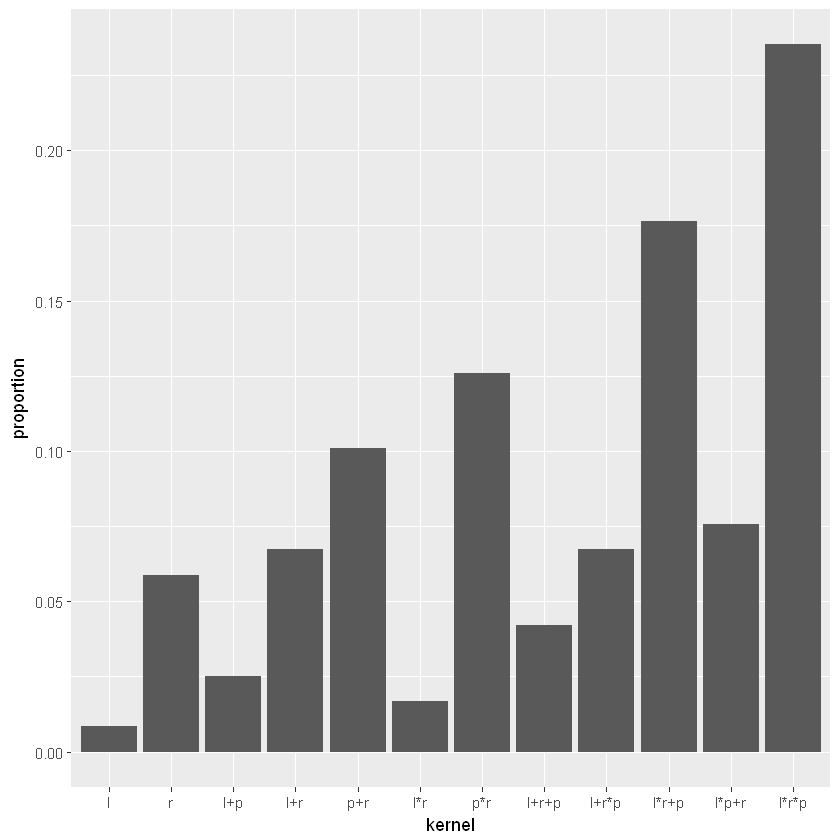

In [109]:
dplot %>%
    ggplot(aes(x=kernel, y=proportion)) + 
    geom_bar(stat="identity")